## Q1.1
I am choosing to use Linear Regression because Cook’s Distance is derived directly from the ordinary least squares framework and measures the influence of individual observations on the estimated regression coefficients. Since the goal of this task is outlier detection, OLS provides the most interpretable applying Cook’s Distance.

## Q1.2

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

import statsmodels.api as sm

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

In [4]:
# load dataset
DATA_PATH = "usina_with_outliers.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())

target_col = df.columns[-1]  # PE
print("Target column:", target_col)

Shape: (9568, 5)


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


Target column: PE


In [5]:
# prepare X and y
df_clean = df.dropna().copy()
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

In [6]:
x_const = sm.add_constant(X) # add intercept for statsmodels OLS
model = sm.OLS(y, x_const).fit() # fit the linear regression model
influence = model.get_influence() # calculate Cook's distance
# cooks_distance returns a tuple:(cooks_distances, p_values)
cooks_d, p_values = influence.cooks_distance
print("Cook's Distances:")
print(cooks_d)

Cook's Distances:
[2.44006091e-05 8.45771786e-06 1.41759928e-04 ... 2.26080986e-05
 2.77235888e-05 2.04541487e-06]


In [7]:
# outlier threshold
n = len(df_clean)
threshold = 4 / n
# identify influential points above threshold
outlier_mask = cooks_d > threshold
outlier_idx = df_clean.index[outlier_mask]

In [8]:
df_clean_outlier = df.drop(index=outlier_idx).reset_index(drop=True)

In [9]:
OUTPUT_NAME = "usina.csv"
df_clean_outlier.to_csv(OUTPUT_NAME, index=False)

## Q2


In [10]:
# Helper Methods
def eval_metrics(y_true, y_pred):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return {
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2":  r2_score(y_true, y_pred),
    }

def standardized_coef_unscaled(beta, X_train_raw, y_train_raw):
    """Standardized coefficients (effect size) for unscaled data:
       beta_std = beta * (std(X)/std(y)), computed using TRAIN statistics.
    """
    std_x = np.std(X_train_raw, axis=0, ddof=0)
    std_y = float(np.std(y_train_raw, axis=0, ddof=0))
    std_y = std_y if std_y > 0 else 1.0
    return beta * (std_x / std_y)

def convert_scaled_coef_to_original(beta_scaled, intercept_scaled, x_scaler: StandardScaler, y_scaler: StandardScaler):
    """Convert coefficients from (X_scaled, y_scaled) space to original units."""
    x_mean = x_scaler.mean_
    x_std  = x_scaler.scale_
    y_mean = float(y_scaler.mean_)
    y_std  = float(y_scaler.scale_)

    beta_orig = (y_std * beta_scaled) / x_std
    intercept_orig = y_mean + y_std * intercept_scaled - np.sum((y_std * beta_scaled * x_mean) / x_std)
    return beta_orig, intercept_orig


In [11]:
def train_and_evaluate(df, target_col):

  X = df.drop(columns=[target_col]).copy()
  y = df[target_col].values.reshape(-1, 1)

  # train/test split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.30, random_state=42, shuffle=True
  )

  models = {
      "Linear": LinearRegression(),
      "Ridge(alpha=1.0)": Ridge(alpha=1.0, random_state=42),
      "Lasso(alpha=1.0)": Lasso(alpha=1.0, max_iter=50000, random_state=42),
  }

  lambdas = [0.01, 0.1, 1, 10, 100]

  rows = []

  # Linear Regression
  lin = LinearRegression()
  lin.fit(X_train, y_train)
  rows.append({
      "model": "Linear",
      "lambda": None,
      **{f"train_{k}": v for k, v in eval_metrics(y_train, lin.predict(X_train)).items()},
      **{f"test_{k}": v for k, v in eval_metrics(y_test, lin.predict(X_test)).items()},
  })

  # Ridge
  for lam in lambdas:
        ridge = Ridge(alpha=lam, random_state=42)
        ridge.fit(X_train, y_train)

        rows.append({
            "model": "Ridge",
            "lambda": lam,
            **{f"train_{k}": v for k, v in eval_metrics(y_train, ridge.predict(X_train)).items()},
            **{f"test_{k}": v for k, v in eval_metrics(y_test, ridge.predict(X_test)).items()},
        })

  # Lasso
  for lam in lambdas:
        lasso = Lasso(alpha=lam, max_iter=50000, random_state=42)
        lasso.fit(X_train, y_train)

        rows.append({
            "model": "Lasso",
            "lambda": lam,
            **{f"train_{k}": v for k, v in eval_metrics(y_train, lasso.predict(X_train)).items()},
            **{f"test_{k}": v for k, v in eval_metrics(y_test, lasso.predict(X_test)).items()},
        })


  return pd.DataFrame(rows)

In [12]:
# WITH outliers
df_outliers = pd.read_csv("usina_with_outliers.csv")
TARGET_COL = df_outliers.columns[-1]

results_outliers = train_and_evaluate(
    df_outliers,
    TARGET_COL
)
display(results_outliers)

# AFTER removing outliers
df_clean = pd.read_csv("usina.csv")

results_clean = train_and_evaluate(
    df_clean,
    TARGET_COL
)

print("Results after removing outliers:")
display(results_clean)

,model,lambda,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
0,Linear,NaN,123.384207,5.198679,0.650171,125.113389,5.052458,0.642574
1,Ridge,0.01,123.384207,5.198679,0.650171,125.113389,5.052458,0.642574
2,Ridge,0.10,123.384207,5.198680,0.650171,125.113392,5.052459,0.642574
3,Ridge,1.00,123.384207,5.198685,0.650171,125.113421,5.052463,0.642574
4,Ridge,10.00,123.384207,5.198737,0.650171,125.113705,5.052513,0.642573
5,Ridge,100.00,123.384213,5.199261,0.650171,125.116548,5.053003,0.642565
6,Lasso,0.01,123.384210,5.198858,0.650171,125.115332,5.052626,0.642568
7,Lasso,0.10,123.384607,5.201739,0.650169,125.134495,5.055348,0.642514
8,Lasso,1.00,123.421151,5.229507,0.650066,125.338356,5.083092,0.641931
9,Lasso,10.00,126.141514,5.540418,0.642353,128.902136,5.408803,0.631750


Results after removing outliers:


,model,lambda,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
0,Linear,NaN,19.864671,3.596396,0.931369,20.396772,3.624773,0.930302
1,Ridge,0.01,19.864671,3.596396,0.931369,20.396772,3.624773,0.930302
2,Ridge,0.10,19.864671,3.596397,0.931369,20.396770,3.624773,0.930302
3,Ridge,1.00,19.864671,3.596400,0.931369,20.396750,3.624774,0.930302
4,Ridge,10.00,19.864672,3.596430,0.931369,20.396549,3.624783,0.930303
5,Ridge,100.00,19.864758,3.596742,0.931369,20.394626,3.624880,0.930310
6,Lasso,0.01,19.864675,3.596368,0.931369,20.396738,3.624754,0.930302
7,Lasso,0.10,19.865263,3.596855,0.931367,20.392600,3.624890,0.930316
8,Lasso,1.00,19.929852,3.605523,0.931144,20.414755,3.631153,0.930241
9,Lasso,10.00,25.685683,4.086632,0.911258,26.157253,4.120464,0.910618


- Do outliers change train error? Test error?
  - Outliers increase train error and  test error. After removing outliers, errors reduced significantly.
- Which dataset (with outliers vs without outliers) shows better generalization?
  - The dataset without outliers shows better generalization because of the small gap between training and test error, and lower test MSE with higher test R^2.
- Do Ridge/Lasso appear to help relative to standard linear regression?
  - Ridge and Lasso do not help in this experiment. Test errors and R² values are almost the same. Removing outliers contribute more to the performance.

## Q3
- Why did you choose this model (Linear vs Ridge vs Lasso)?
  *   I am choosing Linear because coefficient reliability is best defined under the OLS framework.
- Why did you choose this library (Statsmodels vs scikit-learn)?
  *   I am choosing Statsmodels instead of scikit-learn because Statsmodels directly provides t-statistics and p-values, which presents the reliability of regression coefficients. Scikit-learn focuses on prediction and does not report these statistics.
- Would you scale IVs and/or DV for this coefficient reliability task?
  *   I am leaving variables unscaled because scaling has no effect on reliablity.

In [13]:
# read outlier-removed data
df = pd.read_csv("usina.csv")
TARGET_COL = df.columns[-1]

# split
X = df.drop(columns=[TARGET_COL]).copy()
y = df[TARGET_COL].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)

# Fit OLS on train data
X_train_const = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_train_const).fit()

summary_df = pd.DataFrame({
    "feature": ols.params.index,
    "coef": ols.params.values,
    "t_value": ols.tvalues.values,
    "p_value": ols.pvalues.values
})

# drop intercept
summary_df_no_const = summary_df[summary_df["feature"] != "const"].copy()

# sort by |t| for reliability
summary_sorted = summary_df_no_const.sort_values(
    by="t_value", key=lambda s: np.abs(s), ascending=False
)

display(summary_sorted)

most_reliable = summary_sorted.iloc[0]
least_reliable = summary_sorted.iloc[-1]

print("Most reliable coefficient:")
print(most_reliable.to_string(index=False))

print("\nLeast reliable coefficient:")
print(least_reliable.to_string(index=False))


,feature,coef,t_value,p_value
1,AT,-1.966193,-108.971834,0.000000e+00
4,RH,-0.150944,-31.237663,6.360165e-200
2,V,-0.234557,-27.390969,1.487453e-156
3,AP,0.072105,6.438038,1.295207e-10


Most reliable coefficient:
         AT
  -1.966193
-108.971834
        0.0

Least reliable coefficient:
       AP
 0.072105
 6.438038
      0.0


💡 Larger absolute t-value (and smaller p-value) means the coefficient is more reliably different from zero. The most reliable coefficient is the feature with the largest |t|, and the least reliable coefficient is the feature with the smallest |t| (typically with a high p-value).

## Q4
- Why did you choose this model (Linear vs Ridge vs Lasso)?
  *   I am choosing Linear because coefficient reliability is best defined under the OLS framework.
- Why did you choose this library (Statsmodels vs scikit-learn)?
  *   I am choosing Statsmodels because Statsmodels directly provides t-statistics and p-values, which is useful for comparing feature importance.
- Would you scale IVs and/or DV for this coefficient reliability task?
  *   I would scale IVs but not DV because feature importance depends on relative effect size, and unscaled coefficients can be misleading when features have different units.

In [14]:
# read data
df = pd.read_csv("usina.csv")
TARGET_COL = df.columns[-1]

# split
X = df.drop(columns=[TARGET_COL]).copy()
y = df[TARGET_COL].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)

# scale IVs
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)

# Fit OLS on train data
X_train_const = sm.add_constant(X_train_sc)
ols = sm.OLS(y_train, X_train_const).fit()

# Coefficient table (drop intercept)
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": ols.params[1:]  # skip intercept
})

# sort by absolute coefficient value
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_sorted = coef_df.sort_values("abs_coef", ascending=False)

display(coef_sorted)

# Most / least important
most_important = coef_sorted.iloc[0]
least_important = coef_sorted.iloc[-1]

print("Most important feature:", most_important["feature"])
print("Least important feature:", least_important["feature"])

,feature,coef,abs_coef
x1,AT,-14.637188,14.637188
x2,V,-2.979022,2.979022
x4,RH,-2.230954,2.230954
x3,AP,0.428372,0.428372


Most important feature: AT
Least important feature: AP


💡 AT is the most important feature because it has the largest absolute coefficient, while AP is the least important feature because it has the smallest absolute coefficient.

## Q5

In [15]:
import matplotlib.pyplot as plt

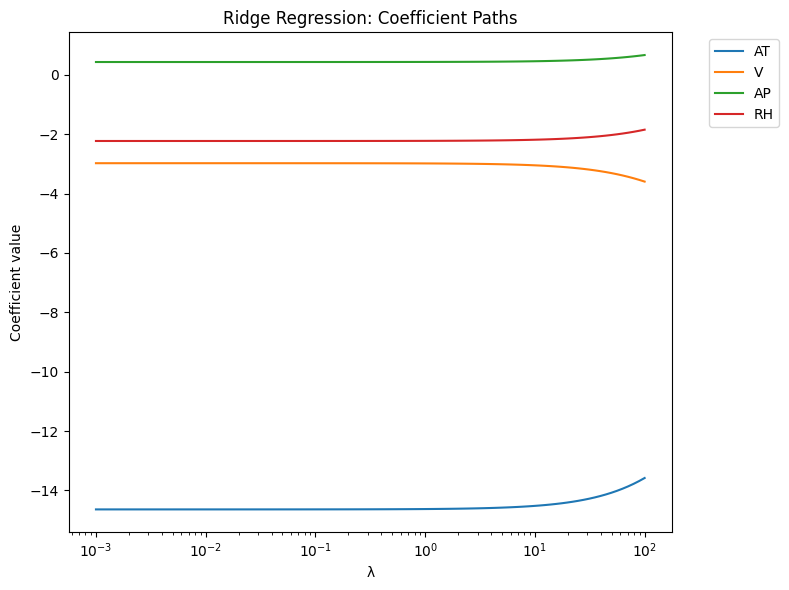

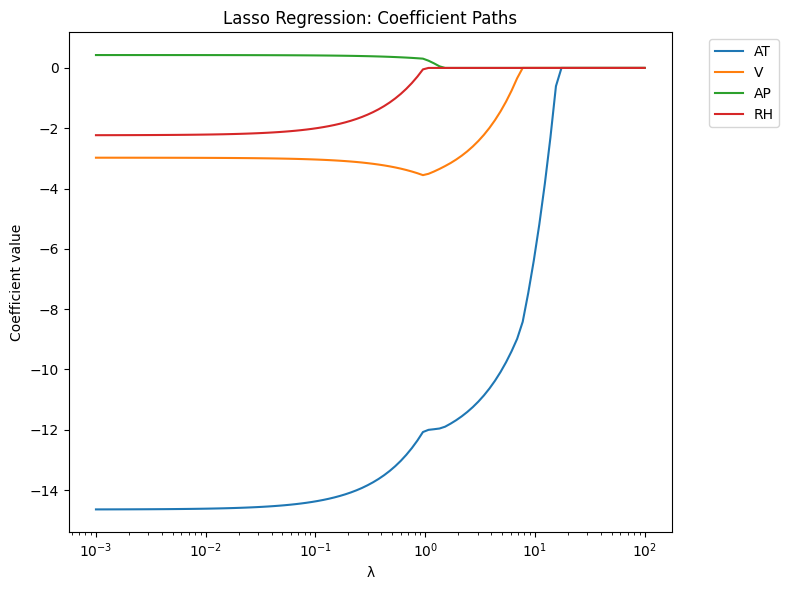

In [16]:
feature_names = X.columns.tolist()
lambdas = np.logspace(-3, 2, 100)  # 0.001 → 100

ridge_coefs = []

for lam in lambdas:
    ridge = Ridge(alpha=lam)
    ridge.fit(X_train_sc, y_train)
    ridge_coefs.append(ridge.coef_)

ridge_coefs = np.array(ridge_coefs)

lasso_coefs = []

for lam in lambdas:
    lasso = Lasso(alpha=lam, max_iter=50000)
    lasso.fit(X_train_sc, y_train)
    lasso_coefs.append(lasso.coef_)

lasso_coefs = np.array(lasso_coefs)

# plotting ridge
plt.figure(figsize=(8, 6))
for i, feature in enumerate(feature_names):
    plt.plot(lambdas, ridge_coefs[:, i], label=feature)

plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("Coefficient value")
plt.title("Ridge Regression: Coefficient Paths")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# plotting lasso
plt.figure(figsize=(8, 6))
for i, feature in enumerate(feature_names):
    plt.plot(lambdas, lasso_coefs[:, i], label=feature)

plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("Coefficient value")
plt.title("Lasso Regression: Coefficient Paths")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



* What happens to coefficients as λ increases in Ridge vs Lasso?
  *  Ridge: as λ increases, all coefficients shrink smoothly and they do not go to zero.
  *  Lasso: as λ increases, coefficients shrinks and then goes to zero exactly.
* Which regression is better under multicollinearity in IVs, and why?
  *  Ridge regression is better under multicollinearity because it stabilizes correlated coefficients.
* Which regression is better for feature selection, and why?
  *  Lasso regression is better for feature selection because its L1 penalty drives unimportant coefficients exactly to zero. We can tell how important a feature is by looking at the curve in Lasso graph. Features that go to zero quickly are less important.

